### **[ Q.3 ] DMW_A3: Letter Recognition Using SVM (Markov Sampling)**
----
### **1. Importing libraries**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import random
from collections import Counter

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import train_test_split
from sklearn import svm

### **2. Data Pre-processing and Visualization**

In [2]:
letters = pd.read_csv("letter-recognition1.csv")

#Print dimension of data
print("Data dimension: ",letters.shape)

Data dimension:  (20000, 17)


In [3]:
# What the data looks like?
letters.head(15)

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
5,S,4,11,5,8,3,8,8,6,9,5,6,6,0,8,9,7
6,B,4,2,5,4,4,8,7,6,6,7,6,6,2,8,7,10
7,A,1,1,3,2,1,8,2,2,2,8,2,8,1,6,2,7
8,J,2,2,4,4,2,10,6,2,6,12,4,8,1,6,1,7
9,M,11,15,13,9,7,13,2,6,2,12,1,9,8,1,1,8


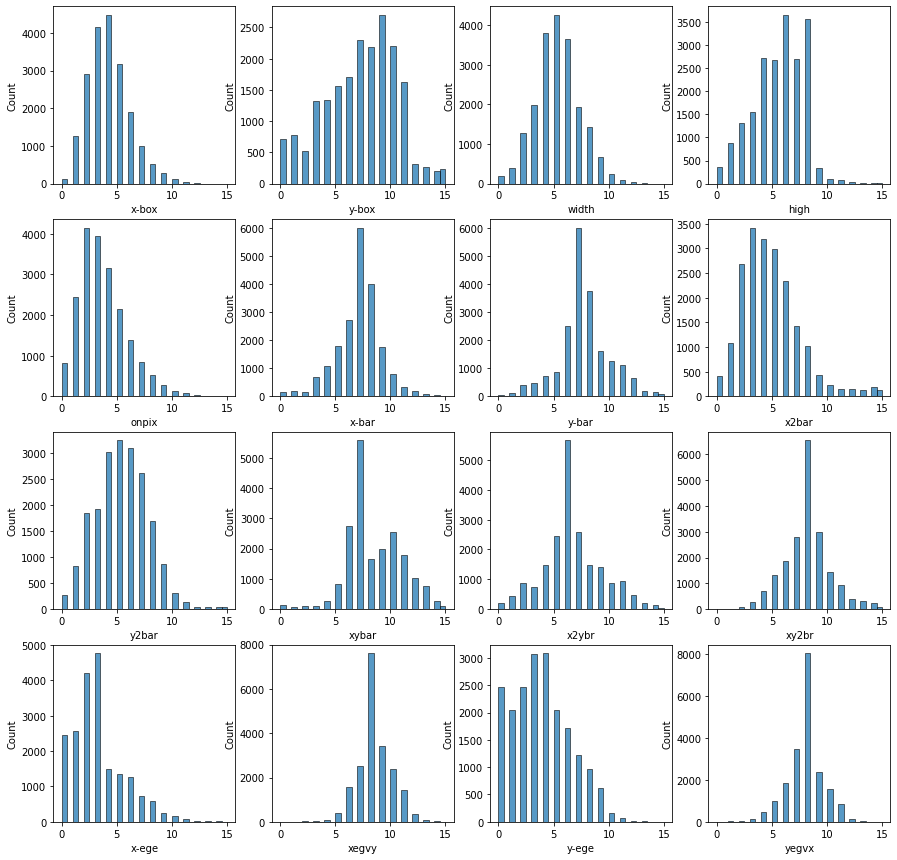

In [4]:
plt.figure(figsize=(15,15))

for i in range(1, 17):
    plt.subplot(4, 4, i)
    sns.histplot(letters.iloc[:, i], bins=30)
    
plt.show()

In [5]:
# What letters does the dataset contain?
order = list(np.sort(letters['lettr'].unique()))
total = list(letters['lettr'])

freq1 = {}

for i in total:
    if i not in freq1:
        freq1[i] = 1
    else:
        freq1[i] += 1

freq = dict(sorted(freq1.items()))
perc = [i/200 for i in freq.values()]
freq_df = pd.DataFrame(freq.items(), columns=['Letter', 'Frequency'])
freq_df['Percentage(%)'] = perc
freq_df

,Letter,Frequency,Percentage(%)
0,A,789,3.945
1,B,766,3.830
2,C,736,3.680
3,D,805,4.025
4,E,768,3.840
5,F,775,3.875
6,G,773,3.865
7,H,734,3.670
8,I,755,3.775
9,J,747,3.735


### **3. Splitting data into X and y.**

In [6]:
X = letters.iloc[:,1:].values
y = letters['lettr']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)
X

array([[ 2,  8,  3, ...,  8,  0,  8],
       [ 5, 12,  3, ...,  8,  4, 10],
       [ 4, 11,  6, ...,  7,  3,  9],
       ...,
       [ 6,  9,  6, ..., 12,  2,  4],
       [ 2,  3,  4, ...,  9,  5,  8],
       [ 4,  9,  6, ...,  7,  2,  8]])

### **4. Markov Chain**

In [7]:
class MarkovModel:

    def __init__(self, currState):
        self.currState = currState
        self.matrix = {state: Counter() for state in self.currState}

    def prob_of_chain(self, chain):
        """
        Compute the prob for a given chain of text to occur.
        """
        prob = 1.0
        for state, next_state in zip(chain, chain[1:]):
            row = self.matrix[state]  
            if next_state not in row:
                return 0

            prob = prob*row[next_state]
        return prob

    def generate_chain(self, begin_state, size):
        """
        Generate of probable chain of state, respecting the probabilities in the matrix
        """
        chain = [begin_state]
        state = begin_state
        for n in range(0, size):
            state = self.next_state(state)
            chain.append(state)
        return chain

    def train(self, chain):
        """
        Train the model on an example chain
        """
        # We read the text two words by two words
        for s1, s2 in zip(chain, chain[1:]):
            self.matrix[s1][s2] += 1

        factor = 1.0 / (len(chain) - 1)  
        for row in self.matrix.values():
            for state, occ in row.items():
                row[state] *= factor

### Model Testing with Different Kernels

In [8]:
acc_array = []

-----
-----
#### **Linear**

In [9]:
# linear model

model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

# predict
predicted_linear = model_linear.predict(X_test)

# confusion matrix and accuracy

# accuracy
lin_acc = metrics.accuracy_score(y_true=y_test, y_pred=predicted_linear)
acc_array.append(str(1-float(lin_acc))[:4])
print("accuracy:", lin_acc*100, "\n")

accuracy: 84.89999999999999 



-----
-----
#### **RBF**

In [10]:
model_linear = SVC(kernel='rbf')
model_linear.fit(X_train, y_train)

# predict
predicted_rbf = model_linear.predict(X_test)

# confusion matrix and accuracy

# accuracy
rbf_acc = metrics.accuracy_score(y_true=y_test, y_pred=predicted_rbf)
acc_array.append(str(1-float(rbf_acc))[:4])
print("accuracy:", rbf_acc*100, "\n")

accuracy: 91.95 



-----
-----
#### **Intersection**

In [11]:
def intersection(data_1, data_2):

    if np.any(data_1 < 0) or np.any(data_2 < 0):
        warnings.warn('Min kernel requires data to be strictly positive!')

    kernel = np.zeros((data_1.shape[0], data_2.shape[0]))

    for d in range(data_1.shape[1]):
        column_1 = data_1[:, d].reshape(-1, 1)
        column_2 = data_2[:, d].reshape(-1, 1)
        kernel += np.minimum(column_1, column_2.T)

    return kernel

# Intersection Kernel
model_intersection = SVC(kernel=intersection, C=1E01,tol=0.1)
model_intersection.fit(X_train, y_train)
predicted_intersection = model_intersection.predict(X_test)
print("Intersection Kernel Done")

Intersection Kernel Done


In [12]:
int_acc = metrics.accuracy_score(y_true=y_test, y_pred=predicted_intersection)
acc_array.append(str(1-float(int_acc))[:4])
print("accuracy:", int_acc*100, "\n")

accuracy: 92.0 



-----
-----
### **Hellinger**

In [13]:
from scipy.linalg import norm


helllinger = "poly"     # sqrt(2) with default precision np.float64


def hellinger1(p, q):
    helinger = norm(np.sqrt(p) - np.sqrt(q)) / np.sqrt(2)
    return helllinger

# Hellinger Kernel
model_hellinger = SVC(kernel=helllinger, C=1E01,tol=0.1)
model_hellinger.fit(X_train, y_train)
predicted_hellinger = model_hellinger.predict(X_test)

hell_accuracy = metrics.accuracy_score(y_test, predicted_hellinger)
acc_array.append(str(1-float(hell_accuracy))[:4])
print("accuracy: ",hell_accuracy*100)

accuracy:  94.88333333333333


-----
-----
#### **χ2**

In [14]:
# Chi^2 Kernel
model_chi2 = SVC(kernel=chi2_kernel, C=1E01,tol=0.1)
model_chi2.fit(X_train, y_train)
predicted_chi2 = model_chi2.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted_chi2)
acc_array.append(str(1-float(accuracy))[:4])
print("accuracy: ", accuracy*100, "%")

accuracy:  97.2 %


In [15]:
#Display all the letters actual and predicted
pd.set_option('display.max_columns', 26)

pd.crosstab(predicted_rbf, y_test)

lettr,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
row_0,,,,,,,,,,,,,,,,,,,,,,,,,,
A,202,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,2,0
B,0,201,0,9,1,0,1,8,0,0,1,2,3,3,0,2,0,12,7,0,0,5,1,1,0,0
C,0,0,206,0,1,0,3,1,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D,0,6,0,231,0,2,4,9,2,3,3,0,0,1,2,2,0,1,0,1,0,0,0,4,0,0
E,0,0,8,0,215,0,1,0,0,0,0,3,0,0,0,2,3,0,3,1,0,0,0,2,0,4
F,0,0,0,0,2,211,2,1,4,0,0,0,0,0,0,13,0,0,6,1,0,0,0,0,0,1
G,1,1,8,0,8,1,197,4,0,0,0,4,1,0,0,5,1,2,0,1,0,0,1,0,0,0
H,0,0,1,1,0,2,0,162,0,0,2,0,1,2,0,2,0,0,0,2,1,0,1,0,1,0
I,0,0,0,0,0,1,0,0,192,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### **Tabular Representation**

In [16]:
table = pd.DataFrame(columns=['Kernel', 'KPCA', 'SVDD', 'OCSVM', 'OCSSVM', 'OCSSVM with SMO', 'MS_SVM'])
table['Kernel'] = ['Linear', 'RBF', 'Intersection', 'Hellinger', 'χ2']
table['KPCA'] = ['0.02', '0.05', '0.18', '0.01', '0.18']
table['SVDD'] = ['0.09', '0.07', '0.01', '0.02', '0.00']
table['OCSVM'] = ['0.01', '0.14', '0.04', '0.02', '0.02']
table['OCSSVM'] = ['0.07', '0.09', '0.26', '0.13', '0.18']
table['OCSSVM with SMO'] = ['0.04', '0.04', '0.22', '0.10', '0.17']
table['MS_SVM'] = acc_array
table

,Kernel,KPCA,SVDD,OCSVM,OCSSVM,OCSSVM with SMO,MS_SVM
0,Linear,0.02,0.09,0.01,0.07,0.04,0.15
1,RBF,0.05,0.07,0.14,0.09,0.04,0.08
2,Intersection,0.18,0.01,0.04,0.26,0.22,0.07
3,Hellinger,0.01,0.02,0.02,0.13,0.10,0.05
4,χ2,0.18,0.00,0.02,0.18,0.17,0.02


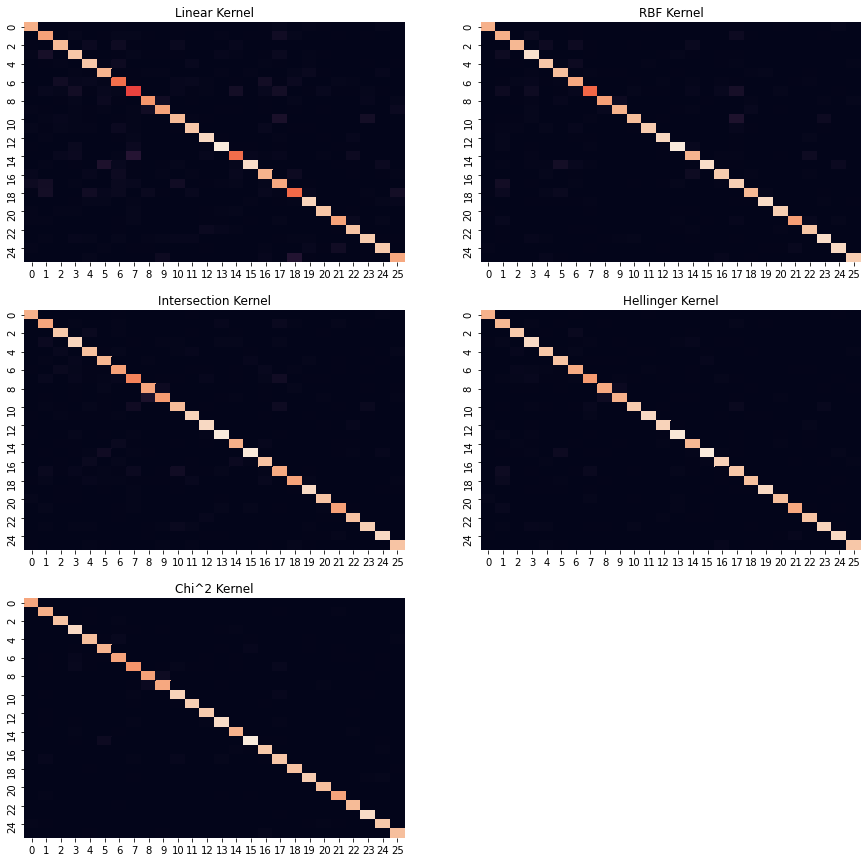

In [17]:
from sklearn.metrics import confusion_matrix

plt.subplots(figsize=(15,15))

plt.subplot(3,2,1)
cf_matrix = confusion_matrix(y_test, predicted_linear)
plt.title('Linear Kernel')
sns.heatmap(cf_matrix, cbar=False)

plt.subplot(3,2,2)
cf_matrix = confusion_matrix(y_test, predicted_rbf)
plt.title('RBF Kernel')
sns.heatmap(cf_matrix, cbar=False)

plt.subplot(3,2,3)
cf_matrix = confusion_matrix(y_test, predicted_intersection)
plt.title('Intersection Kernel')
sns.heatmap(cf_matrix, cbar=False)

plt.subplot(3,2,4)
cf_matrix = confusion_matrix(y_test, predicted_hellinger)
plt.title('Hellinger Kernel')
sns.heatmap(cf_matrix, cbar=False)

plt.subplot(3,2,5)
cf_matrix = confusion_matrix(y_test, predicted_chi2)
plt.title('Chi^2 Kernel')
sns.heatmap(cf_matrix, cbar=False)

plt.show()